In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [4]:
master_df = pd.read_csv('worldometer_coronavirus_daily_data_latest.csv')
master_df.head()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-2-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-2-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-2-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
3,2020-2-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
4,2020-2-19,Afghanistan,0.0,NaN,0.0,0.0,NaN


In [5]:
master_df.tail()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
152730,2022-1-01,Zimbabwe,214214.0,956.0,26786.0,5017.0,13.0
152731,2022-1-02,Zimbabwe,214878.0,664.0,26585.0,5032.0,15.0
152732,2022-1-03,Zimbabwe,216087.0,1209.0,25446.0,5047.0,15.0
152733,2022-1-04,Zimbabwe,217678.0,1591.0,24620.0,5078.0,31.0
152734,2022-1-05,Zimbabwe,219057.0,1379.0,24252.0,5092.0,14.0


In [6]:
master_df.shape

(152735, 7)

In [7]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152735 entries, 0 to 152734
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     152735 non-null  object 
 1   country                  152735 non-null  object 
 2   cumulative_total_cases   152735 non-null  float64
 3   daily_new_cases          145244 non-null  float64
 4   active_cases             147898 non-null  float64
 5   cumulative_total_deaths  145825 non-null  float64
 6   daily_new_deaths         129468 non-null  float64
dtypes: float64(5), object(2)
memory usage: 8.2+ MB


In [8]:
master_df.isnull().sum()

date                           0
country                        0
cumulative_total_cases         0
daily_new_cases             7491
active_cases                4837
cumulative_total_deaths     6910
daily_new_deaths           23267
dtype: int64

In [9]:
df = master_df[master_df['country'] == 'India']

In [10]:
df.isnull().sum()

date                       0
country                    0
cumulative_total_cases     0
daily_new_cases            1
active_cases               0
cumulative_total_deaths    0
daily_new_deaths           5
dtype: int64

In [11]:
df.fillna(0,inplace=True)

In [12]:
df.reset_index(drop=True,inplace=True)

In [13]:
df = df[df['daily_new_cases'] != 0]

In [14]:
df.reset_index(inplace=True,drop=True)

In [15]:
df

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-3-02,India,6.0,3.0,3.0,0.0,0.0
1,2020-3-03,India,7.0,1.0,4.0,0.0,0.0
2,2020-3-04,India,29.0,22.0,26.0,0.0,0.0
3,2020-3-05,India,30.0,1.0,27.0,0.0,0.0
4,2020-3-06,India,31.0,1.0,28.0,0.0,0.0
...,...,...,...,...,...,...,...
669,2022-1-01,India,34889132.0,27553.0,122801.0,481770.0,284.0
670,2022-1-02,India,34922882.0,33750.0,156428.0,481893.0,123.0
671,2022-1-03,India,34960261.0,37379.0,182837.0,482017.0,124.0
672,2022-1-04,India,35018358.0,58097.0,214004.0,482551.0,534.0


In [16]:
time = pd.date_range(start='3/2/2020',periods=674,freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['date','country'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [17]:
df.head()

,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
time_stamp,,,,,
2020-03-02,6.0,3.0,3.0,0.0,0.0
2020-03-03,7.0,1.0,4.0,0.0,0.0
2020-03-04,29.0,22.0,26.0,0.0,0.0
2020-03-05,30.0,1.0,27.0,0.0,0.0
2020-03-06,31.0,1.0,28.0,0.0,0.0


In [18]:
df.tail()

,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
time_stamp,,,,,
2021-12-31,34889132.0,27553.0,122801.0,481770.0,284.0
2022-01-01,34922882.0,33750.0,156428.0,481893.0,123.0
2022-01-02,34960261.0,37379.0,182837.0,482017.0,124.0
2022-01-03,35018358.0,58097.0,214004.0,482551.0,534.0
2022-01-04,35109286.0,90928.0,284155.0,482876.0,325.0


In [19]:
df = df[['daily_new_cases']]

In [20]:
df

,daily_new_cases
time_stamp,
2020-03-02,3.0
2020-03-03,1.0
2020-03-04,22.0
2020-03-05,1.0
2020-03-06,1.0
...,...
2021-12-31,27553.0
2022-01-01,33750.0
2022-01-02,37379.0


In [21]:
df.head()

,daily_new_cases
time_stamp,
2020-03-02,3.0
2020-03-03,1.0
2020-03-04,22.0
2020-03-05,1.0
2020-03-06,1.0


In [22]:
df.tail()

,daily_new_cases
time_stamp,
2021-12-31,27553.0
2022-01-01,33750.0
2022-01-02,37379.0
2022-01-03,58097.0
2022-01-04,90928.0


In [23]:
df.shape

(674, 1)

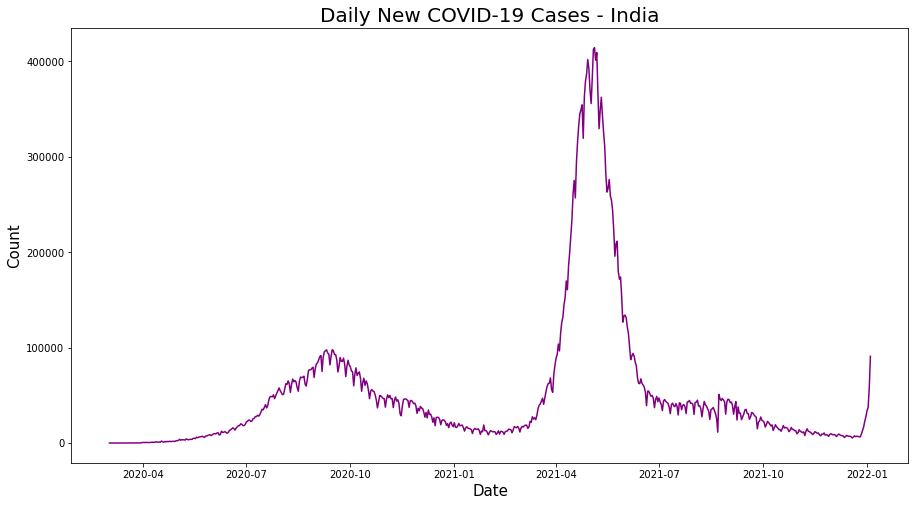

In [24]:
plt.plot(df,color='purple')
plt.title('Daily New COVID-19 Cases - India',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [25]:
plt.rcParams['figure.figsize'] = [15,8]

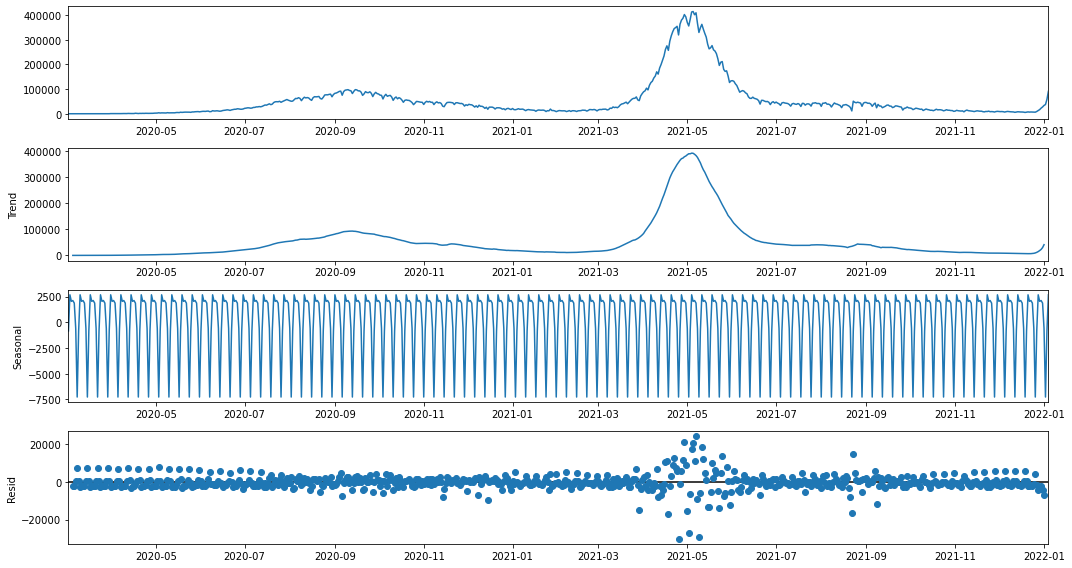

In [26]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

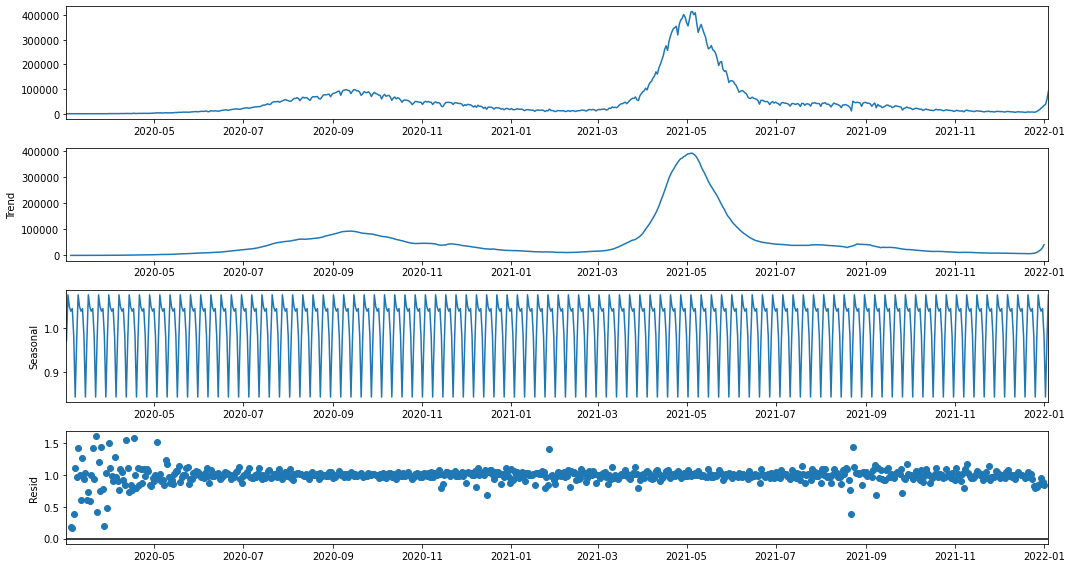

In [27]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

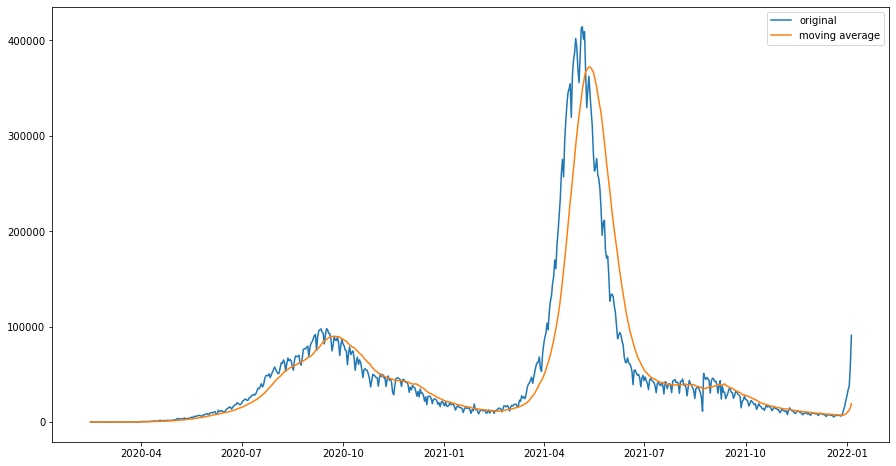

In [49]:
plt.plot(df,label='original')
plt.plot(df.rolling(20,min_periods=0).mean(),label='moving average')
plt.legend(loc='best')
plt.show()

In [21]:
# Model building - Exponential Smoothing Techniques

In [28]:
train = df.iloc[:610]
test = df.iloc[610:]

In [29]:
train.tail()

,daily_new_cases
time_stamp,
2021-10-28,14189.0
2021-10-29,12958.0
2021-10-30,12935.0
2021-10-31,9769.0
2021-11-01,10796.0


In [30]:
test.head()

,daily_new_cases
time_stamp,
2021-11-02,13965.0
2021-11-03,12265.0
2021-11-04,11680.0
2021-11-05,10879.0
2021-11-06,11648.0


In [31]:
len(train)

610

In [32]:
len(test)

64

##### Simple Exponential Smoothing

In [33]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(smoothing_level = 0.1950000)
SES_model.summary()

Dep. Variable:,daily_new_cases,No. Observations:,610
Model:,SimpleExpSmoothing,SSE,187467879827.303
Optimized:,True,AIC,11925.483
Trend:,None,BIC,11934.310
Seasonal:,None,AICC,11925.549
Seasonal Periods:,None,Date:,"Wed, 30 Mar 2022"
Box-Cox:,False,Time:,14:44:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1950000,alpha,False
initial_level,3.0666667,l.0,True


In [107]:
SES_predict = SES_model.forecast(len(test))

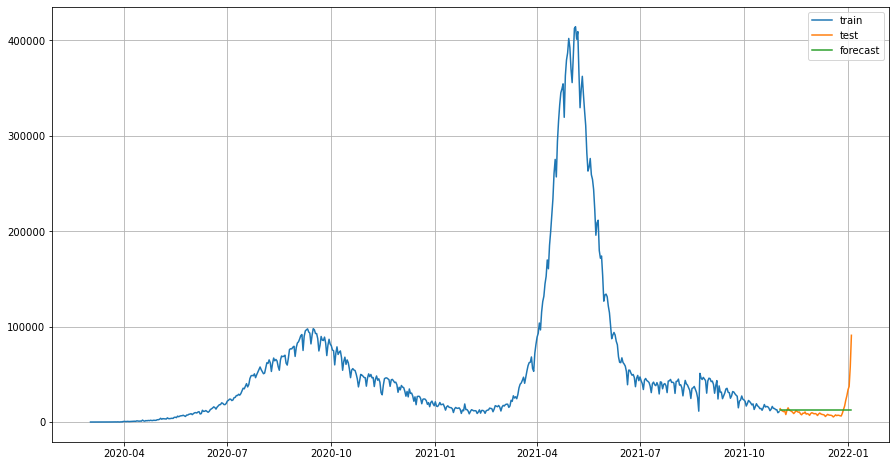

In [108]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [109]:
print("MAE:",MAE(test['daily_new_cases'],SES_predict))
print("MAPE:",MAPE(test['daily_new_cases'],SES_predict))

MAE: 6537.337479679553
MAPE: 51.063059868161744


##### Double Exponential Smoothing

In [134]:
DES = Holt(train,exponential=False,initialization_method='estimated')
DES_model = DES.fit(smoothing_level = 0.571429,
                   smoothing_trend = 0.002000000)
DES_model.summary()

Dep. Variable:,daily_new_cases,No. Observations:,610
Model:,Holt,SSE,48654148337.134
Optimized:,True,AIC,11106.672
Trend:,Additive,BIC,11124.326
Seasonal:,None,AICC,11106.811
Seasonal Periods:,None,Date:,"Tue, 29 Mar 2022"
Box-Cox:,False,Time:,12:13:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5714290,alpha,False
smoothing_trend,0.0020000,beta,False


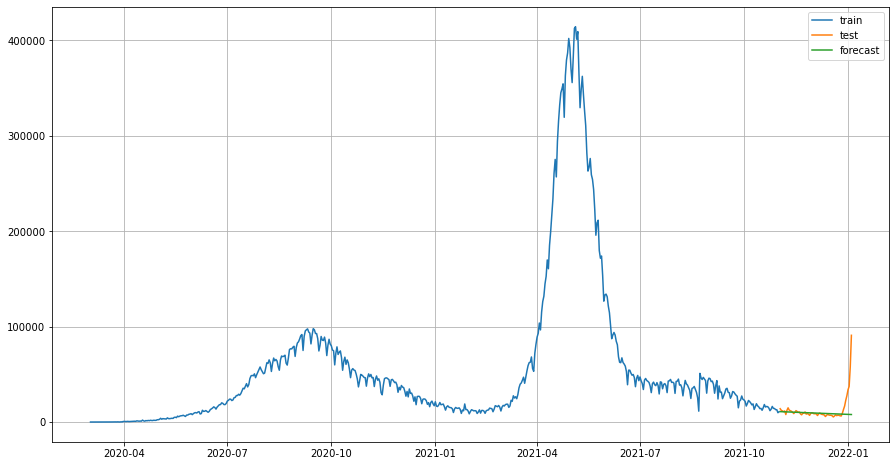

In [135]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [136]:
print("MAE:",MAE(test['daily_new_cases'],DES_predict))
print("MAPE:",MAPE(test['daily_new_cases'],DES_predict))

MAE: 4901.829049499633
MAPE: 23.668068257957913


##### Triple Exponential Smoothing

In [261]:
TES = ExponentialSmoothing(train,trend='multiplicative',seasonal='multiplicative',initialization_method='estimated')
TES_model = TES.fit(smoothing_level=0.1039286,
                   smoothing_trend=0.1901587,
                   smoothing_seasonal=0.1081331)
TES_model.summary()

Dep. Variable:,daily_new_cases,No. Observations:,610
Model:,ExponentialSmoothing,SSE,262772552831.794
Optimized:,True,AIC,12149.468
Trend:,Multiplicative,BIC,12198.016
Seasonal:,Multiplicative,AICC,12150.079
Seasonal Periods:,7,Date:,"Tue, 29 Mar 2022"
Box-Cox:,False,Time:,12:26:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1039286,alpha,False
smoothing_trend,0.1901587,beta,False


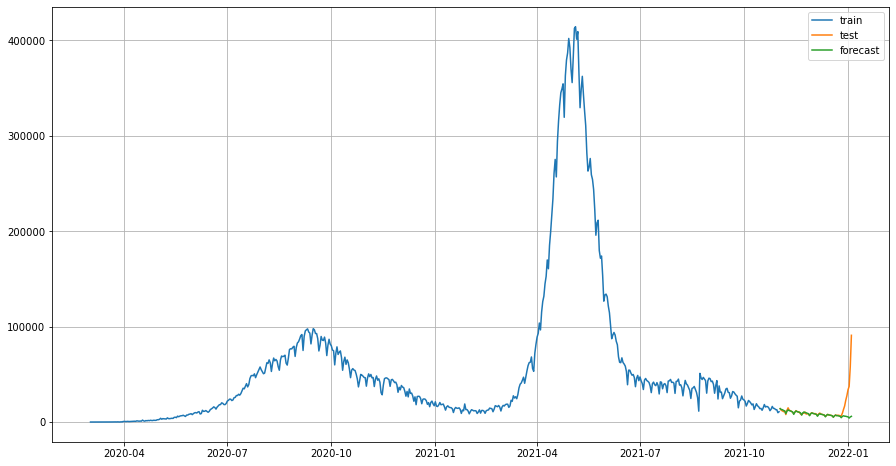

In [262]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [263]:
print("MAE:",MAE(test['daily_new_cases'],TES_predict))
print("MAPE:",MAPE(test['daily_new_cases'],TES_predict))

MAE: 4465.44443658475
MAPE: 15.127958541305977


##### ACF and PACF plots

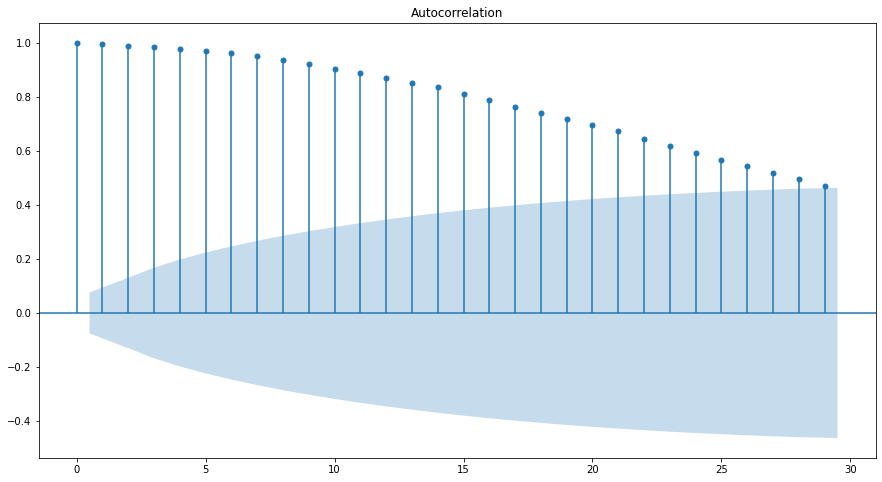

In [264]:
plot_acf(df)
plt.show()

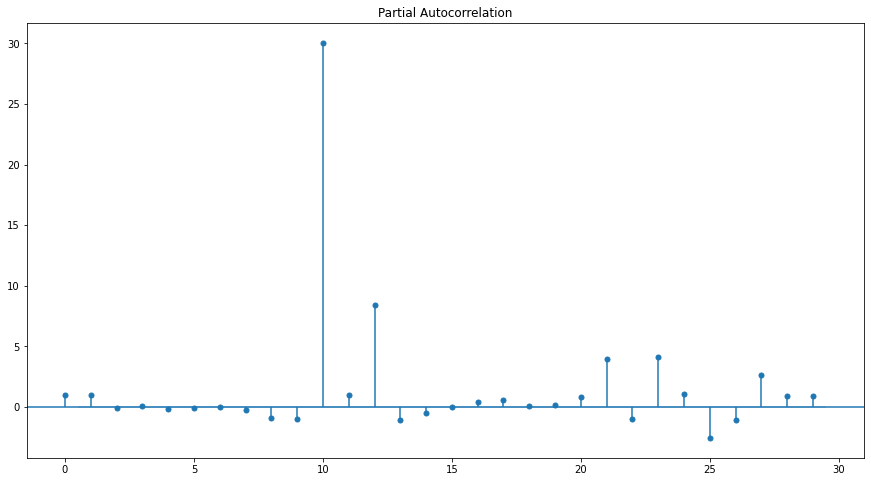

In [265]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [266]:
observations = df.values
df_results = adfuller(observations)
df_results

(-2.4415851593582234,
 0.1303415417633576,
 20,
 653,
 {'1%': -3.4404038931945276,
  '5%': -2.865976260062519,
  '10%': -2.5691324834372633},
 12918.405241614662)

In [87]:
##### Non-stationary series -- proceed with ARIMA & SARIMA model

In [267]:
df_diff = df.diff(periods=1).dropna()
val = df_diff.values
df_diff_results = adfuller(val)
df_diff_results

(-4.401121257672272,
 0.0002954792945571416,
 19,
 653,
 {'1%': -3.4404038931945276,
  '5%': -2.865976260062519,
  '10%': -2.5691324834372633},
 12903.817999883075)

##### ARIMA Model

In [268]:
import itertools

In [269]:
p = q = range(0,11)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
print("Parameter combinations are:")
for i in range(1,len(pdq)):
    print("ARIMA",pdq[i])

Parameter combinations are:
ARIMA (0, 1, 1)
ARIMA (0, 1, 2)
ARIMA (0, 1, 3)
ARIMA (0, 1, 4)
ARIMA (0, 1, 5)
ARIMA (0, 1, 6)
ARIMA (0, 1, 7)
ARIMA (0, 1, 8)
ARIMA (0, 1, 9)
ARIMA (0, 1, 10)
ARIMA (1, 1, 0)
ARIMA (1, 1, 1)
ARIMA (1, 1, 2)
ARIMA (1, 1, 3)
ARIMA (1, 1, 4)
ARIMA (1, 1, 5)
ARIMA (1, 1, 6)
ARIMA (1, 1, 7)
ARIMA (1, 1, 8)
ARIMA (1, 1, 9)
ARIMA (1, 1, 10)
ARIMA (2, 1, 0)
ARIMA (2, 1, 1)
ARIMA (2, 1, 2)
ARIMA (2, 1, 3)
ARIMA (2, 1, 4)
ARIMA (2, 1, 5)
ARIMA (2, 1, 6)
ARIMA (2, 1, 7)
ARIMA (2, 1, 8)
ARIMA (2, 1, 9)
ARIMA (2, 1, 10)
ARIMA (3, 1, 0)
ARIMA (3, 1, 1)
ARIMA (3, 1, 2)
ARIMA (3, 1, 3)
ARIMA (3, 1, 4)
ARIMA (3, 1, 5)
ARIMA (3, 1, 6)
ARIMA (3, 1, 7)
ARIMA (3, 1, 8)
ARIMA (3, 1, 9)
ARIMA (3, 1, 10)
ARIMA (4, 1, 0)
ARIMA (4, 1, 1)
ARIMA (4, 1, 2)
ARIMA (4, 1, 3)
ARIMA (4, 1, 4)
ARIMA (4, 1, 5)
ARIMA (4, 1, 6)
ARIMA (4, 1, 7)
ARIMA (4, 1, 8)
ARIMA (4, 1, 9)
ARIMA (4, 1, 10)
ARIMA (5, 1, 0)
ARIMA (5, 1, 1)
ARIMA (5, 1, 2)
ARIMA (5, 1, 3)
ARIMA (5, 1, 4)
ARIMA (5, 1, 5)
ARIMA (

In [182]:
df_score_arima = pd.DataFrame(columns=['param','aic'])
df_score_arima

,param,aic


In [183]:
from warnings import filterwarnings
filterwarnings('ignore')

In [184]:
for param in pdq:
    try:
        model = ARIMA(train,order=param)
        arima_results = model.fit()
        print("ARIMA",param,"AIC:",arima_results.aic)
        df_score_arima = df_score_arima.append({'param':param,'aic':arima_results.aic},ignore_index=True)
    except:
        continue

ARIMA (0, 1, 0) AIC: 12852.494250836655
ARIMA (0, 1, 1) AIC: 12848.621463345426
ARIMA (0, 1, 2) AIC: 12847.292883012493
ARIMA (0, 1, 3) AIC: 12840.25681650524
ARIMA (0, 1, 4) AIC: 12816.383250858577
ARIMA (0, 1, 5) AIC: 12796.855812276433
ARIMA (0, 1, 6) AIC: 12717.768022663933
ARIMA (0, 1, 7) AIC: 12532.796259250512
ARIMA (0, 1, 8) AIC: 12533.488304254828
ARIMA (0, 1, 9) AIC: 12532.481856813105
ARIMA (0, 1, 10) AIC: 12534.116197254121
ARIMA (1, 1, 0) AIC: 12849.479901163322
ARIMA (1, 1, 1) AIC: 12816.69043109466
ARIMA (1, 1, 2) AIC: 12830.274004464414
ARIMA (1, 1, 3) AIC: 12714.687976242283
ARIMA (1, 1, 4) AIC: 12715.132303067445
ARIMA (1, 1, 5) AIC: 12717.068659371667
ARIMA (1, 1, 6) AIC: 12656.803086690883
ARIMA (1, 1, 8) AIC: 12530.577297181058
ARIMA (1, 1, 9) AIC: 12532.549734855702
ARIMA (1, 1, 10) AIC: 12482.493813626867
ARIMA (2, 1, 0) AIC: 12848.981097199223
ARIMA (2, 1, 1) AIC: 12830.27045377427
ARIMA (2, 1, 2) AIC: 12799.94294532908
ARIMA (2, 1, 3) AIC: 12718.454833757172
AR

In [185]:
df_score_arima.sort_values('aic')

,param,aic
94,"(9, 1, 6)",12277.084535
95,"(9, 1, 7)",12279.050773
76,"(7, 1, 8)",12279.736225
96,"(9, 1, 8)",12280.374504
77,"(7, 1, 9)",12281.226864
...,...,...
2,"(0, 1, 2)",12847.292883
1,"(0, 1, 1)",12848.621463
21,"(2, 1, 0)",12848.981097
11,"(1, 1, 0)",12849.479901


##### ARIMA Model - 1

In [552]:
arima_model = ARIMA(train,(10,1,1))
arima_results = arima_model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  609
Model:                ARIMA(10, 1, 1)   Log Likelihood               -6034.777
Method:                       css-mle   S.D. of innovations           4841.807
Date:                Tue, 29 Mar 2022   AIC                          12095.555
Time:                        15:04:38   BIC                          12152.909
Sample:                    03-03-2020   HQIC                         12117.867
                         - 11-01-2021                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       17.7225    489.452      0.036      0.971    -941.586     977.031
ar.L1.D.daily_new_cases      0.6787      0.059     11.573      0.000       0.564       0.

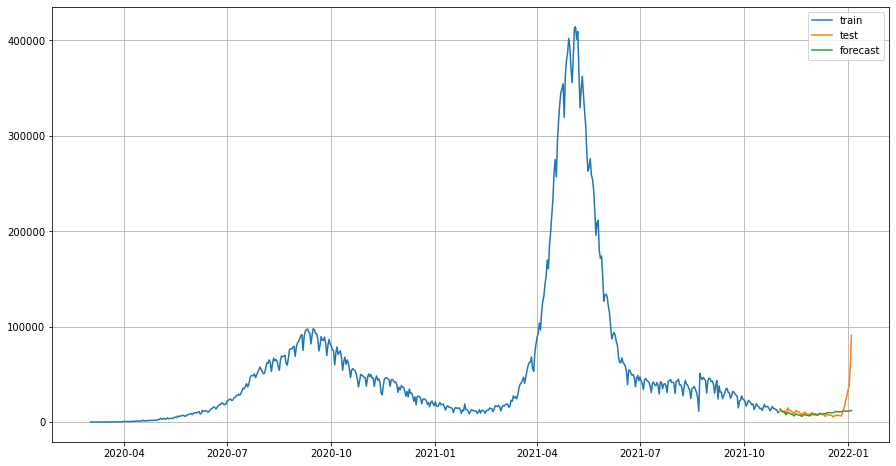

In [553]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [554]:
print("MAE:",MAE(test['daily_new_cases'],forecasted_values_arima))
print("MAPE:",MAPE(test['daily_new_cases'],forecasted_values_arima))

MAE: 5150.667311079143
MAPE: 29.98172045714671


##### ARIMA Model - 2

In [555]:
arima_model = ARIMA(train,(10,1,2))
arima_results = arima_model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  609
Model:                ARIMA(10, 1, 2)   Log Likelihood               -6033.388
Method:                       css-mle   S.D. of innovations           4830.602
Date:                Tue, 29 Mar 2022   AIC                          12094.776
Time:                        15:06:14   BIC                          12156.541
Sample:                    03-03-2020   HQIC                         12118.804
                         - 11-01-2021                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       17.7224    482.292      0.037      0.971    -927.553     962.998
ar.L1.D.daily_new_cases      0.1359      0.193      0.704      0.482      -0.243       0.

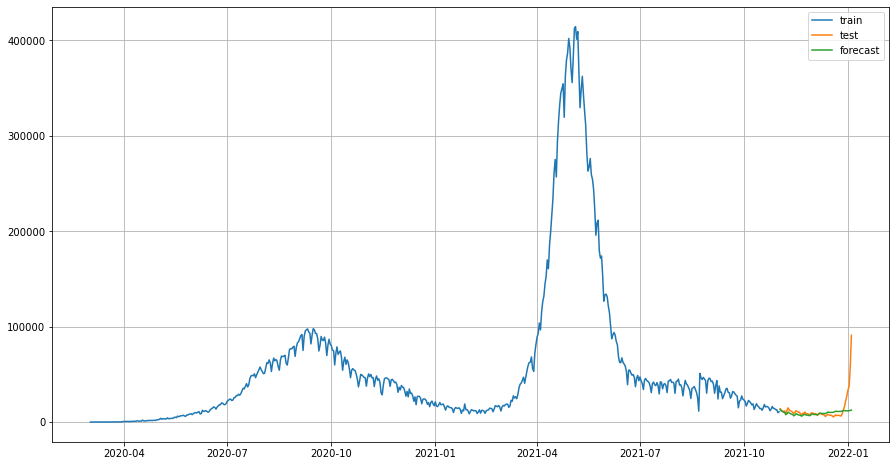

In [556]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [557]:
print("MAE:",MAE(test['daily_new_cases'],forecasted_values_arima))
print("MAPE:",MAPE(test['daily_new_cases'],forecasted_values_arima))

MAE: 5125.913643828612
MAPE: 30.436433811315837


##### ARIMA Model - 3

In [564]:
arima_model = ARIMA(train,(6,1,7))
arima_results = arima_model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  609
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -6051.445
Method:                       css-mle   S.D. of innovations           4977.823
Date:                Tue, 29 Mar 2022   AIC                          12132.890
Time:                        15:07:50   BIC                          12199.067
Sample:                    03-03-2020   HQIC                         12158.634
                         - 11-01-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      17.7225    732.546      0.024      0.981   -1418.041    1453.486
ar.L1.D.daily_new_cases     0.7978      0.051     15.709      0.000       0.698       0.897


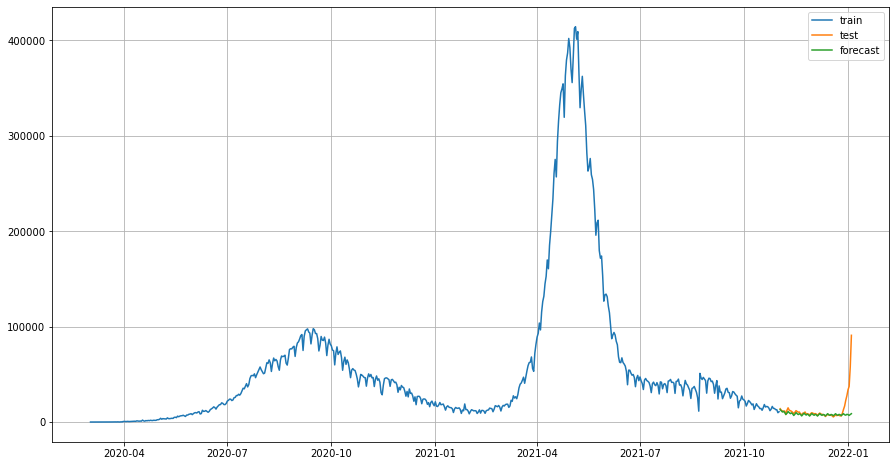

In [565]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [568]:
print("MAE:",MAE(test['daily_new_cases'],forecasted_values_arima))
print("MAPE:",MAPE(test['daily_new_cases'],forecasted_values_arima))

MAE: 4742.440349686207
MAPE: 19.861204187590747


##### SARIMA Model

In [34]:
import itertools

In [48]:
p = q = range(0,5)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
pdq_seasonal = [(x[0],x[1],x[2],10) for x in list(itertools.product(p,d,q))]

df_score = pd.DataFrame(columns=['param','seasonal','aic'])
df_score

,param,seasonal,aic


In [49]:
for param in pdq:
    for seasonal_param in pdq_seasonal:
        model = SARIMAX(train,
                       order = param,
                       seasonal_order = seasonal_param,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        sarimax_results = model.fit()
        print("SARIMAX",param,seasonal_param,'AIC:',sarimax_results.aic)
        df_score = df_score.append({'param':param,'seasonal':seasonal_param,'aic':sarimax_results.aic},ignore_index=True)

SARIMAX (0, 1, 0) (0, 1, 0, 10) AIC: 12784.415232245396
SARIMAX (0, 1, 0) (0, 1, 1, 10) AIC: 12291.326042411823
SARIMAX (0, 1, 0) (0, 1, 2, 10) AIC: 12096.909854977888
SARIMAX (0, 1, 0) (0, 1, 3, 10) AIC: 11891.690610700334
SARIMAX (0, 1, 0) (0, 1, 4, 10) AIC: 11700.146061329215
SARIMAX (0, 1, 0) (1, 1, 0, 10) AIC: 12432.205516565018
SARIMAX (0, 1, 0) (1, 1, 1, 10) AIC: 12257.848169885778
SARIMAX (0, 1, 0) (1, 1, 2, 10) AIC: 12064.955963879533
SARIMAX (0, 1, 0) (1, 1, 3, 10) AIC: 11859.064765538917
SARIMAX (0, 1, 0) (1, 1, 4, 10) AIC: 11663.543917914547
SARIMAX (0, 1, 0) (2, 1, 0, 10) AIC: 12225.025116548004
SARIMAX (0, 1, 0) (2, 1, 1, 10) AIC: 12077.770217526013
SARIMAX (0, 1, 0) (2, 1, 2, 10) AIC: 12059.591017248738
SARIMAX (0, 1, 0) (2, 1, 3, 10) AIC: 11853.866105456793
SARIMAX (0, 1, 0) (2, 1, 4, 10) AIC: 11647.000276642142
SARIMAX (0, 1, 0) (3, 1, 0, 10) AIC: 12008.457252366043
SARIMAX (0, 1, 0) (3, 1, 1, 10) AIC: 11852.905398100072
SARIMAX (0, 1, 0) (3, 1, 2, 10) AIC: 11852.38364

SARIMAX (1, 1, 0) (4, 1, 2, 10) AIC: 11679.56837526007
SARIMAX (1, 1, 0) (4, 1, 3, 10) AIC: 11678.703285931027
SARIMAX (1, 1, 0) (4, 1, 4, 10) AIC: 11668.959475576477
SARIMAX (1, 1, 1) (0, 1, 0, 10) AIC: 12755.903841349715
SARIMAX (1, 1, 1) (0, 1, 1, 10) AIC: 12273.190397598162
SARIMAX (1, 1, 1) (0, 1, 2, 10) AIC: 12072.950483758425
SARIMAX (1, 1, 1) (0, 1, 3, 10) AIC: 11870.293709628728
SARIMAX (1, 1, 1) (0, 1, 4, 10) AIC: 11650.9526519676
SARIMAX (1, 1, 1) (1, 1, 0, 10) AIC: 12426.751578589474
SARIMAX (1, 1, 1) (1, 1, 1, 10) AIC: 12275.050983350975
SARIMAX (1, 1, 1) (1, 1, 2, 10) AIC: 12071.459653185457
SARIMAX (1, 1, 1) (1, 1, 3, 10) AIC: 11866.853057572525
SARIMAX (1, 1, 1) (1, 1, 4, 10) AIC: 11652.357522197868
SARIMAX (1, 1, 1) (2, 1, 0, 10) AIC: 12224.347992588455
SARIMAX (1, 1, 1) (2, 1, 1, 10) AIC: 12094.468039498086
SARIMAX (1, 1, 1) (2, 1, 2, 10) AIC: 12072.133296539687
SARIMAX (1, 1, 1) (2, 1, 3, 10) AIC: 11862.076160563513
SARIMAX (1, 1, 1) (2, 1, 4, 10) AIC: 11633.56206192

SARIMAX (2, 1, 1) (3, 1, 4, 10) AIC: 11636.765133656298
SARIMAX (2, 1, 1) (4, 1, 0, 10) AIC: 11715.260257183983
SARIMAX (2, 1, 1) (4, 1, 1, 10) AIC: 11604.91397593538
SARIMAX (2, 1, 1) (4, 1, 2, 10) AIC: 11607.534664787632
SARIMAX (2, 1, 1) (4, 1, 3, 10) AIC: 11602.620162139725
SARIMAX (2, 1, 1) (4, 1, 4, 10) AIC: 11596.98798445685
SARIMAX (2, 1, 2) (0, 1, 0, 10) AIC: 12489.041233341904
SARIMAX (2, 1, 2) (0, 1, 1, 10) AIC: 12203.667442786824
SARIMAX (2, 1, 2) (0, 1, 2, 10) AIC: 11963.649868104167
SARIMAX (2, 1, 2) (0, 1, 3, 10) AIC: 11763.550732970989
SARIMAX (2, 1, 2) (0, 1, 4, 10) AIC: 11562.202090876872
SARIMAX (2, 1, 2) (1, 1, 0, 10) AIC: 12293.701375971537
SARIMAX (2, 1, 2) (1, 1, 1, 10) AIC: 12173.027181970981
SARIMAX (2, 1, 2) (1, 1, 2, 10) AIC: 11965.56455968698
SARIMAX (2, 1, 2) (1, 1, 3, 10) AIC: 11762.959360538938
SARIMAX (2, 1, 2) (1, 1, 4, 10) AIC: 11563.0396031108
SARIMAX (2, 1, 2) (2, 1, 0, 10) AIC: 12083.033684546965
SARIMAX (2, 1, 2) (2, 1, 1, 10) AIC: 11983.4893296957

SARIMAX (3, 1, 2) (3, 1, 1, 10) AIC: 11743.905991203654
SARIMAX (3, 1, 2) (3, 1, 2, 10) AIC: 11748.966222574774
SARIMAX (3, 1, 2) (3, 1, 3, 10) AIC: 11743.773109241314
SARIMAX (3, 1, 2) (3, 1, 4, 10) AIC: 11535.92327933116
SARIMAX (3, 1, 2) (4, 1, 0, 10) AIC: 11618.081520378102
SARIMAX (3, 1, 2) (4, 1, 1, 10) AIC: 11534.192393650785
SARIMAX (3, 1, 2) (4, 1, 2, 10) AIC: 11543.331893956236
SARIMAX (3, 1, 2) (4, 1, 3, 10) AIC: 11543.0654269907
SARIMAX (3, 1, 2) (4, 1, 4, 10) AIC: 11541.283453396129
SARIMAX (3, 1, 3) (0, 1, 0, 10) AIC: 12390.31287400172
SARIMAX (3, 1, 3) (0, 1, 1, 10) AIC: 12090.270782776697
SARIMAX (3, 1, 3) (0, 1, 2, 10) AIC: 11849.14764887048
SARIMAX (3, 1, 3) (0, 1, 3, 10) AIC: 11665.34166078562
SARIMAX (3, 1, 3) (0, 1, 4, 10) AIC: 11455.514460051956
SARIMAX (3, 1, 3) (1, 1, 0, 10) AIC: 12190.308951125207
SARIMAX (3, 1, 3) (1, 1, 1, 10) AIC: 12066.464424414631
SARIMAX (3, 1, 3) (1, 1, 2, 10) AIC: 11873.117513039251
SARIMAX (3, 1, 3) (1, 1, 3, 10) AIC: 11671.41874665992

SARIMAX (4, 1, 3) (2, 1, 3, 10) AIC: 11670.302300586663
SARIMAX (4, 1, 3) (2, 1, 4, 10) AIC: 11470.553295775357
SARIMAX (4, 1, 3) (3, 1, 0, 10) AIC: 11748.516524619274
SARIMAX (4, 1, 3) (3, 1, 1, 10) AIC: 11666.190263468488
SARIMAX (4, 1, 3) (3, 1, 2, 10) AIC: 11669.038919552917
SARIMAX (4, 1, 3) (3, 1, 3, 10) AIC: 11668.53599702039
SARIMAX (4, 1, 3) (3, 1, 4, 10) AIC: 11439.425800062338
SARIMAX (4, 1, 3) (4, 1, 0, 10) AIC: 11532.935206790138
SARIMAX (4, 1, 3) (4, 1, 1, 10) AIC: 11415.807167872963
SARIMAX (4, 1, 3) (4, 1, 2, 10) AIC: 11445.480820542969
SARIMAX (4, 1, 3) (4, 1, 3, 10) AIC: 11462.691904860942
SARIMAX (4, 1, 3) (4, 1, 4, 10) AIC: 11404.352633766292
SARIMAX (4, 1, 4) (0, 1, 0, 10) AIC: 12337.401203526771
SARIMAX (4, 1, 4) (0, 1, 1, 10) AIC: 12102.008447308992
SARIMAX (4, 1, 4) (0, 1, 2, 10) AIC: 11855.507639862488
SARIMAX (4, 1, 4) (0, 1, 3, 10) AIC: 11620.239195467586
SARIMAX (4, 1, 4) (0, 1, 4, 10) AIC: 11422.510971293386
SARIMAX (4, 1, 4) (1, 1, 0, 10) AIC: 12169.612439

In [50]:
df_score.sort_values('aic')

,param,seasonal,aic
599,"(4, 1, 3)","(4, 1, 4, 10)",11404.352634
619,"(4, 1, 4)","(3, 1, 4, 10)",11405.670670
624,"(4, 1, 4)","(4, 1, 4, 10)",11407.817253
596,"(4, 1, 3)","(4, 1, 1, 10)",11415.807168
609,"(4, 1, 4)","(1, 1, 4, 10)",11422.195662
...,...,...,...
250,"(2, 1, 0)","(0, 1, 0, 10)",12759.116105
25,"(0, 1, 1)","(0, 1, 0, 10)",12760.270469
275,"(2, 1, 1)","(0, 1, 0, 10)",12768.639028
125,"(1, 1, 0)","(0, 1, 0, 10)",12781.108967


In [71]:
model = SARIMAX(train,
                       order = (0,1,4),
                       seasonal_order = (1,1,1,5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [72]:
print(sarimax_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     daily_new_cases   No. Observations:                  610
Model:             SARIMAX(0, 1, 4)x(1, 1, [1], 5)   Log Likelihood               -6220.127
Date:                             Wed, 30 Mar 2022   AIC                          12454.254
Time:                                     17:34:16   BIC                          12484.962
Sample:                                 03-02-2020   HQIC                         12466.213
                                      - 11-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2171      0.038     -5.686      0.000      -0.292      -0.142
ma.L2         -0.4194      

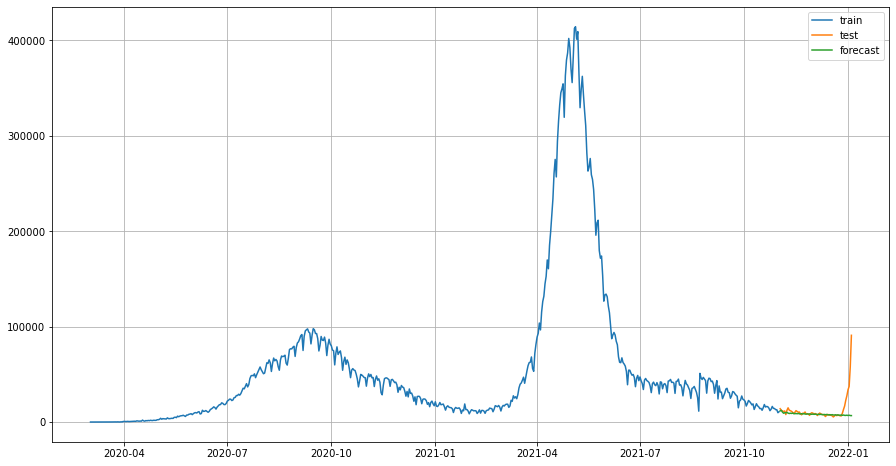

In [73]:
forecast = sarimax_results.forecast(len(test))

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [74]:
print("MAE:",MAE(test['daily_new_cases'],forecast))
print("MAPE:",MAPE(test['daily_new_cases'],forecast))

MAE: 4836.753575592091
MAPE: 20.023844781503257


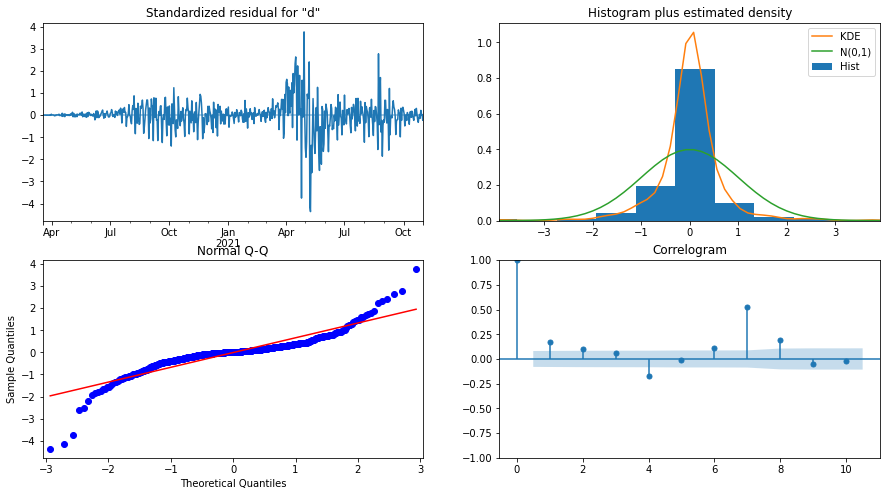

In [75]:
sarimax_results.plot_diagnostics();